# 선형회귀 예시(2) -  의료비에 영향을 미치는 요소

## #01. 작업준비

### 1. 패키지 참조하기

In [24]:
import sys
sys.path.append("../../")
import helper

import numpy as np
from pandas import read_excel, DataFrame, melt, merge,get_dummies
from pca import pca
from pandas.api.types import CategoricalDtype
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from matplotlib import pyplot as plt 
import seaborn as sb
from scipy import stats
import statsmodels.api as sm

### 2. 데이터 가져오기

미국 환자의 의료비가 들어있는 데이터셋으로 `1,338` 개의 관측치가 있다.

|변수|의미|기타|
|---|--|--|
|age|수익자의 연령|수치형|
|sex|계약자의 성별|범주형데이터(female/male)|
|bmi|비만도. 몸무게를 키의 제곱으로 나눈값|수치형 <br> 정상범위 : 18.5~24.9|
|children|의료보험이 적용되는 자녀 수|수치형데이터|
|smoker|흡연여부|범주형데이터(yes/no)|
|region|거주지역|범주형 <br>  (북동:northeast, 남동:southeast, 남서:southwest, 북서:northwest)|
|expense|의료비|수치형데이터|

In [2]:
origin = read_excel("https://data.hossam.kr/E04/insurance.xlsx")
origin 

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## #02. 데이터 전처리
### 1. 데이터 프레임 복사 후 결측치와 데이터 타입 확인

In [3]:
edf = origin.copy()
helper.prettyPrint(edf.isna().sum(), title="결측치 개수")
helper.prettyPrint(edf.dtypes, title='데이터 타입')

+----------+---------------+
|          |   결측치 개수 |
|----------+---------------|
| age      |             0 |
| sex      |             0 |
| bmi      |             0 |
| children |             0 |
| smoker   |             0 |
| region   |             0 |
| charges  |             0 |
+----------+---------------+
+----------+---------------+
|          | 데이터 타입   |
|----------+---------------|
| age      | int64         |
| sex      | object        |
| bmi      | float64       |
| children | int64         |
| smoker   | object        |
| region   | object        |
| charges  | float64       |
+----------+---------------+


### 2. 범주형 타입 변환

범주형 필드 이름

In [4]:
cnames = ['sex', 'smoker', 'region']
cnames

['sex', 'smoker', 'region']

범주형 컬럼 타입 변환 (helper모듈사용)

In [5]:
edf2 = helper.setCategory(edf, fields=cnames, labelling = False)
helper.prettyPrint(edf2.dtypes, title='데이터타입')

+----------+--------------+
|          | 데이터타입   |
|----------+--------------|
| age      | int64        |
| sex      | category     |
| bmi      | float64      |
| children | int64        |
| smoker   | category     |
| region   | category     |
| charges  | float64      |
+----------+--------------+


범주형 컬럼 타입 변환 (helper모듈사용x)

In [6]:
edf=edf.astype({'sex':'category', 'smoker':'category','region':'category'})
edf.dtypes

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
charges      float64
dtype: object

## #03. 탐색적 데이터 분석

### 1. 수치형 변수

#### 1) 기초통계량 확인
수치형 데이터 타입은 전체적인 통계값을 파악하는 것이 좋다.

In [7]:
desc = edf2.describe()
desc

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


> 의료비지출 변수의 통계값을 살펴보면 중앙값이 `$9,382` 이고, 평균이 `$13,270` 인 것을 알 수 있다. 여기서 해당 변수의 평균값이 중앙값보다 크기 때문에 의료비 분포는 오른쪽으로 꼬리가 긴 분포를 지닐 것이다.

#### 2) 전체 상자그림 확인

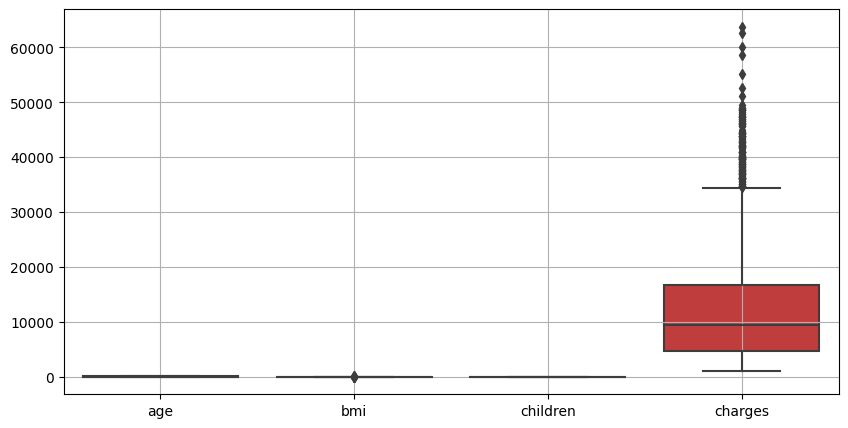

In [8]:
plt.figure(figsize=(10,5))
sb.boxplot(data=edf)
plt.grid()
plt.show()
plt.close()

> 전체 상자그림보다 개별 상자그림을 확인해야 한다.

#### 3) 개별 상자그림 확인

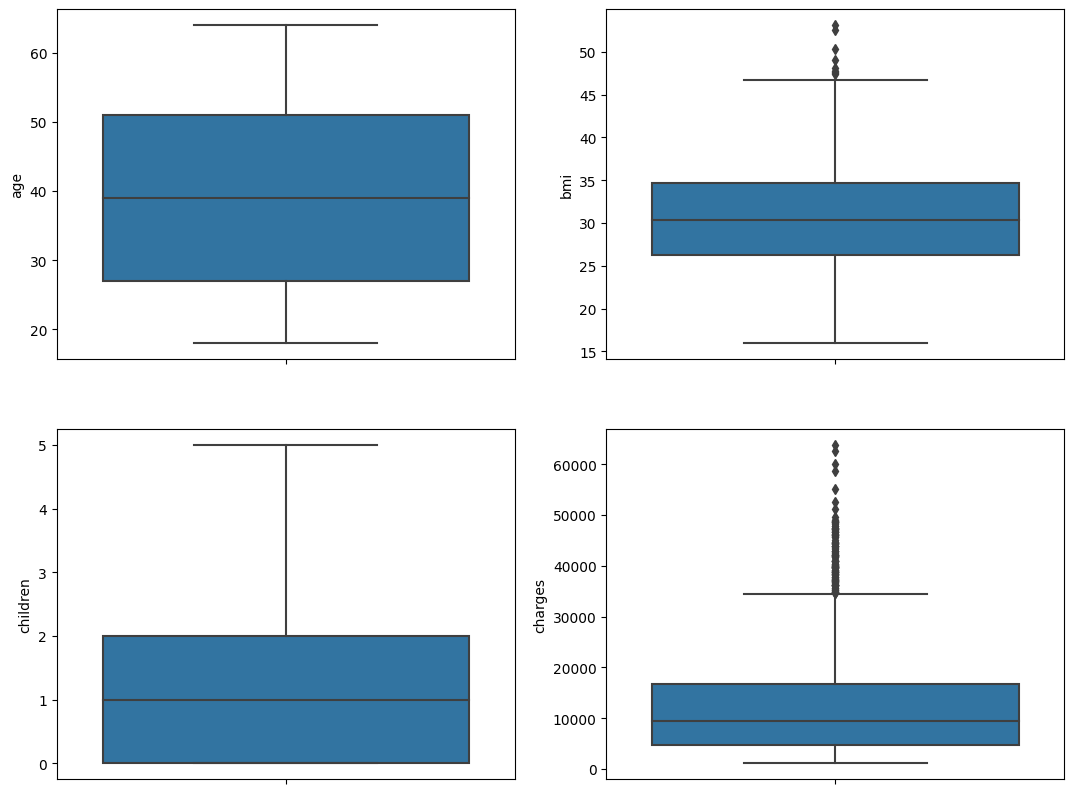

In [9]:
fig, ax = plt.subplots(2,2,figsize=(13,10))
rows = len(ax)
cols = len(ax[0])

for i in range(0,rows):
    for j in range(0, cols):
        idx = i * cols + j
        fieldName = desc.columns[idx]
        field = edf2[fieldName]
        sb.boxplot(edf, y=field, ax=ax[i][j])

        if idx+1 == len(desc.columns):
            break

plt.show()
plt.close()

> bmi에 대한 이상치는 함부로 제거해서는 안된다. 이상치는 무조건 정제하는 건 아님.
비만도 이상치 -> 이상치에서 말하는 사람들도 비만이므로 정제해서는 안된다. 

#### 4) 히스토그램 확인

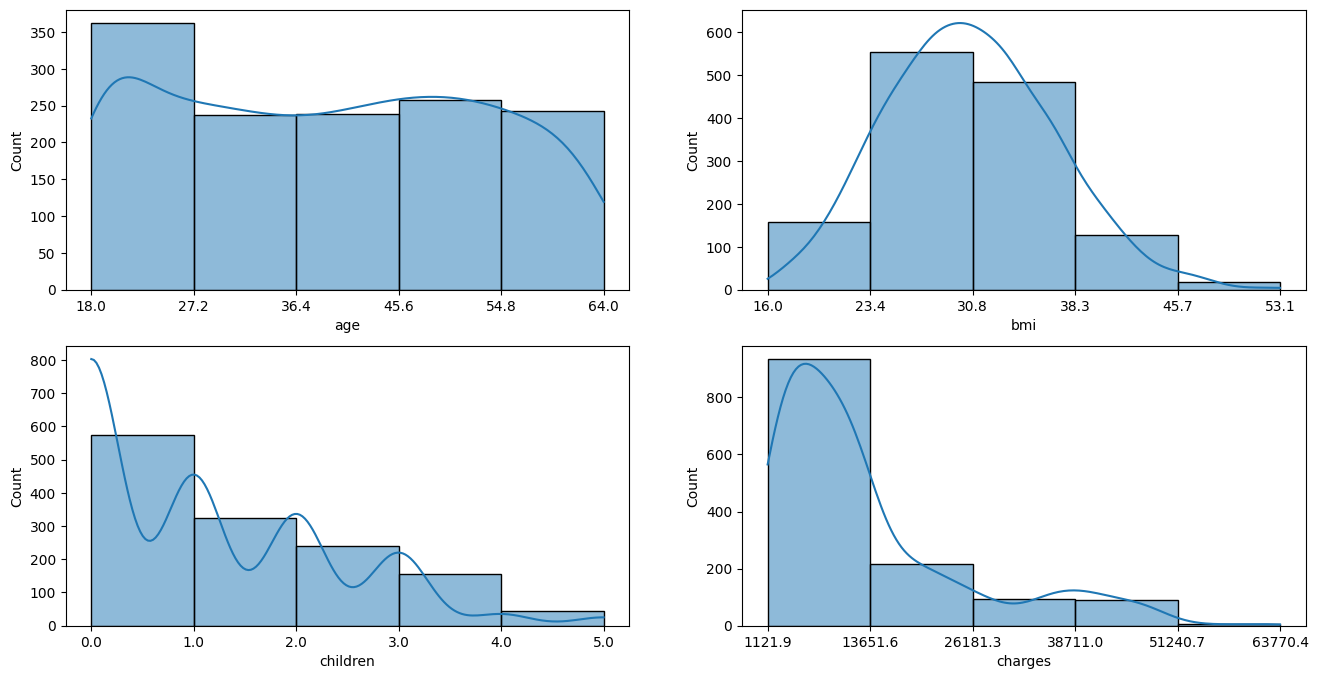

In [10]:
fig, ax = plt.subplots(2,2,figsize=(16,8))
rows = len(ax)
cols = len(ax[0])

for i in range(0,rows):
    for j in range(0, cols):
        idx = i * cols + j
        fieldName = desc.columns[idx]
        field = edf2[fieldName]

        hist, bins = np.histogram(field, bins=5)
        bins2 = np.round(bins, 1)

        sb.histplot(data=edf2, x=fieldName, bins=5, kde=True, ax=ax[i][j])
        ax[i][j].set_xticks(bins)
        ax[i][j].set_xticklabels(bins2)
        
        if idx+1 == len(desc.columns):
            break

plt.show()
plt.close()

### 5) 각 변수간의 관계 파악

#### 수치형 변수들의 이름

In [11]:
nnames = list(desc.columns)
nnames

['age', 'bmi', 'children', 'charges']

In [12]:
ndf = edf.filter(nnames)
ndf.head()

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


#### 산점도 행렬

c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x2000 with 0 Axes>

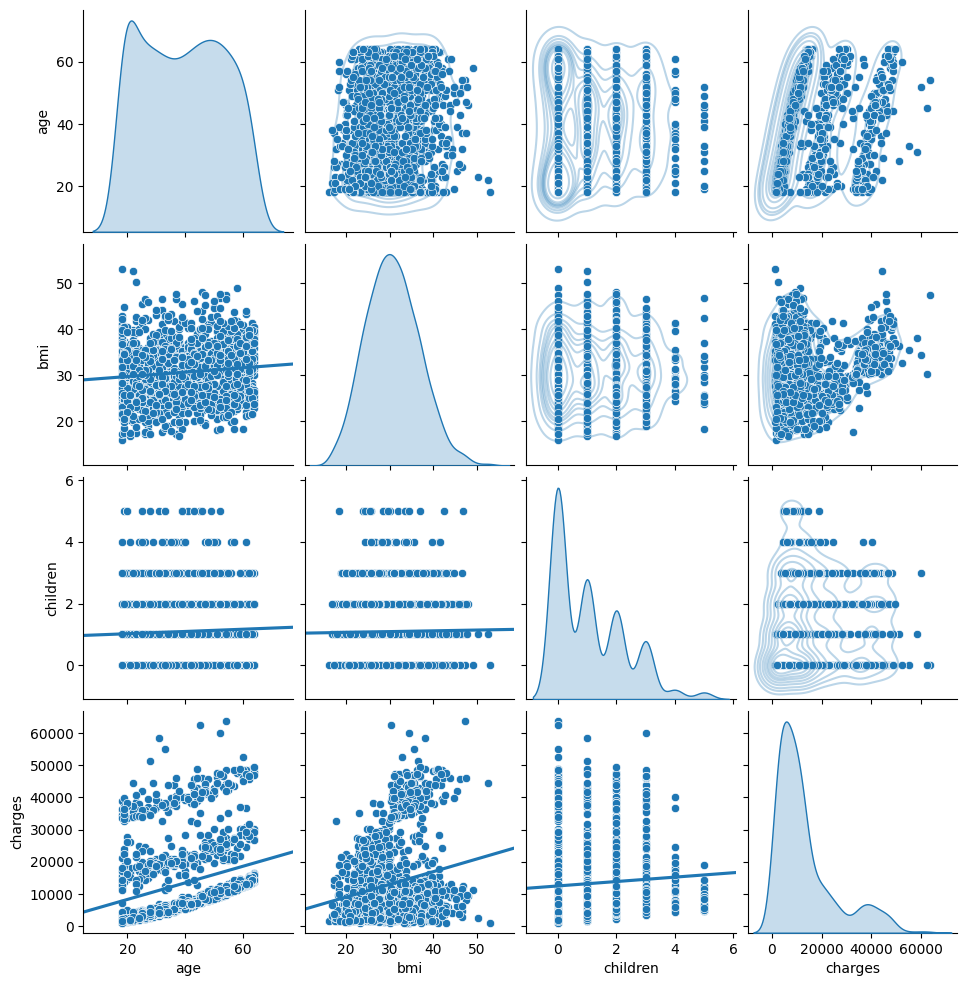

In [13]:
# plt.figure(figsize=(20,20))
# g = sb.pairplot(ndf, diag_kind='kde')
# g.map_upper(sb.kdeplot, alpha=0.3)
# g.map_lower(sb.regplot, scatter=False, truncate=False, ci=False)
# plt.savefig() #소요시간이 오래걸리므로 이미지 저장후 주석처리하기!
# plt.show()
# plt.close()

> 이 그림에서 어떤 패턴이 눈에 띄는지 살펴보면 특정한 관계를 찾기는 어려워보임. <br> 연령과 의료비지출의 산포도를 살펴보니, 상대적으로 직선 형태로 분포되어 있음을 볼 수 있다. <br> 또, bmi지수와 의료비지출은 크게 두 개의 군집(cluster)로 나누어져 있는 것으로 보인다. <br> 전체적으로 강한 상관관계를 보이지는 않지만 `age-bmi`, `age-charges`, `children-charges` 가 약한 상관관계를 보인다. <br> 나이가 들수록 몸무게가 증가하고, bmi수치가 높거나 부양가족 수가 많아질 수록 의료비가 증가하는 것은 어느정도 합리적인 결과라 할 수 있겠다.

#### 상관행렬

대각선은 변수 자신이기 때문에 항상 `1`이 표기됨.

상관계수는 1에 가까울수록 두 변수가 같은 방향으로 양의 상관관계가 높다고 판단할 수 있고, -1에 가까울 수록 반대방향으로 음의 상관관계가 높다는 것을 나타냄

In [14]:
corr = ndf.corr(method = 'pearson')
corr

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


> 연령, bmi지수, 부양가족 수, 의료비지출은 약하지만 모두 양(+)의 상관관계를 보이고 있다. <br>  예를 들어, 연령과 bmi지수는 나이가 들어갈수록 몸무게가 증가되면서 bmi지수가 높아지는 경향을 설명할 수 있고, 부양가족 수가 증가하면 의료비 지출이 많아진다고 보는 것도 합리적인 판단이 될 수 있다.

### 6) PCA 분석

회귀분석에 필요한 요인들을 선정하기 위해 주성분 분석을 수행한다.

#### 데이터 표준화

범주형은 PCA를 수행할 수 없기 때문에 수치형 변수만 추출해둔 ndf를 사용한다.

종속변수인 의료비 필드는 제외하고 진행한다.

In [22]:
x_train_std_df, y_train_std_df = helper.scalling(ndf[nnames], 'charges')
x_train_std_df

,age,bmi,children
0,-1.438764,-0.453320,-0.908614
1,-1.509965,0.509621,-0.078767
2,-0.797954,0.383307,1.580926
3,-0.441948,-1.305531,-0.908614
4,-0.513149,-0.292556,-0.908614
...,...,...,...
1333,0.768473,0.050297,1.580926
1334,-1.509965,0.206139,-0.908614
1335,-1.509965,1.014878,-0.908614
1336,-1.296362,-0.797813,-0.908614


#### PCA

In [23]:
model = pca()
# 표준화 결과를 활용하여 주성분 분석 수행
fit = model.fit_transform(x_train_std_df)
topfeat = fit['topfeat']

best = topfeat.query("type=='best'")
best_names = list(set(list(best['feature'])))
print(best_names)

topfeat

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [3] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [3] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [3] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
['children', 'age']


,PC,feature,loading,type
0,PC1,age,0.692028,best
1,PC2,children,0.931148,best
2,PC3,age,-0.717326,best
3,PC3,bmi,0.669385,weak


### 2. 범주형 변수

#### 1) 종류별로 데이터 수량 확인

In [15]:
for name in cnames:
    helper.prettyPrint(edf2[name].value_counts(), title='count')

+--------+---------+
| sex    |   count |
|--------+---------|
| male   |     676 |
| female |     662 |
+--------+---------+
+----------+---------+
| smoker   |   count |
|----------+---------|
| no       |    1064 |
| yes      |     274 |
+----------+---------+
+-----------+---------+
| region    |   count |
|-----------+---------|
| southeast |     364 |
| northwest |     325 |
| southwest |     325 |
| northeast |     324 |
+-----------+---------+


#### 2) 범주형 데이터의 데이터 분포 시각화

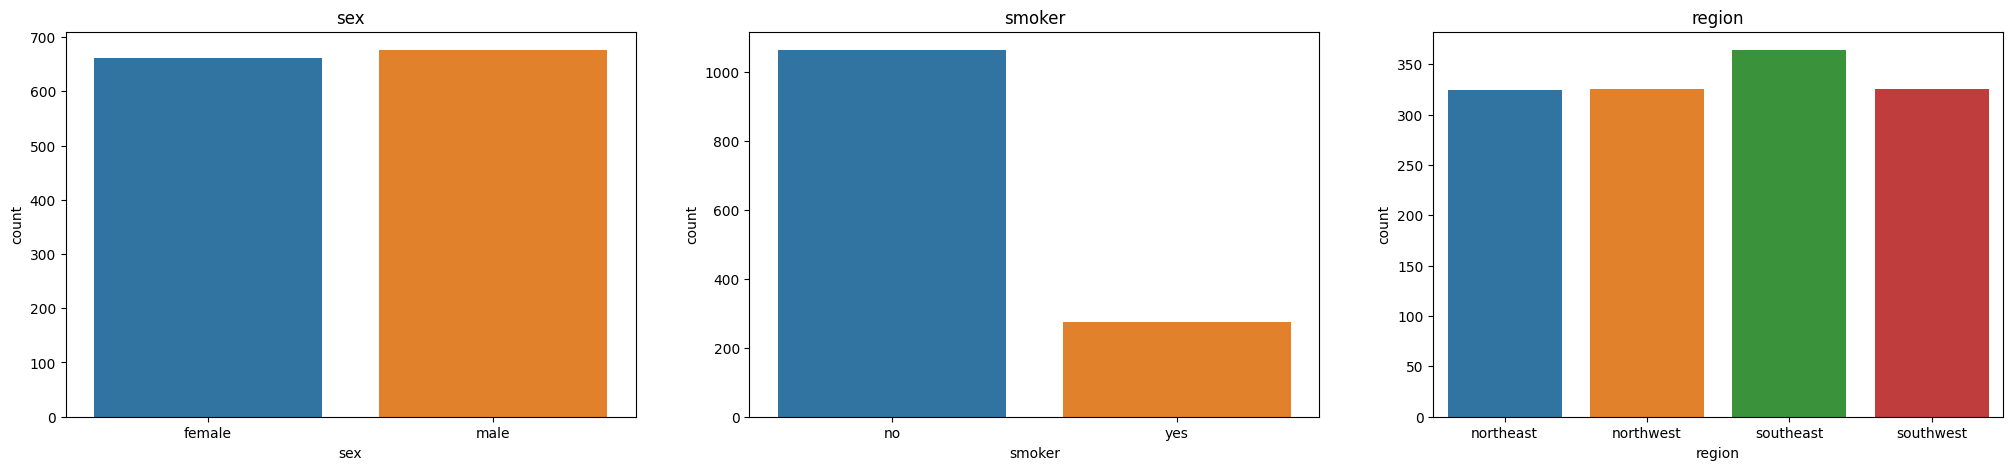

In [16]:
fig, ax = plt.subplots(1, len(cnames), figsize=(25,5))

for i, v in enumerate(cnames):
    vc = DataFrame(edf2[v].value_counts(), columns=['count'])
    sb.barplot(data=vc, x=vc.index, y='count', ax=ax[i])
    ax[i].set_title(v)

plt.show()
plt.close()

### 3) 범주형 변수에 따라 평균이 차이가 나는지 확인하기

#### 라벨링을 적용한 데이터프레임 생성

In [17]:
ldf = helper.setCategory(edf, fields=cnames, labelling=True)
helper.prettyPrint(ldf.dtypes)

+----------+----------+
|          | value    |
|----------+----------|
| age      | int64    |
| sex      | category |
| bmi      | float64  |
| children | int64    |
| smoker   | category |
| region   | category |
| charges  | float64  |
+----------+----------+


#### 분산분석

In [20]:
lm = ols('charges ~ C(sex)+C(smoker)+C(region)+C(sex):C(smoker)+C(smoker):C(region)+C(region):C(sex)+C(sex):C(smoker):C(region)', data=ldf).fit()
lmdf = anova_lm(lm)
lmdf['결과'] = lmdf['PR(>F)'] < 0.05
lmdf

,df,sum_sq,mean_sq,F,PR(>F),결과
C(sex),1.0,6.435902e+08,6.435902e+08,11.730026,6.338371e-04,True
C(smoker),1.0,1.208777e+11,1.208777e+11,2203.108485,7.872124e-284,True
C(region),3.0,1.078004e+08,3.593345e+07,0.654920,5.799028e-01,False
C(sex):C(smoker),1.0,4.904163e+08,4.904163e+08,8.938290,2.844155e-03,True
C(smoker):C(region),3.0,1.344084e+09,4.480281e+08,8.165726,2.181106e-05,True
C(region):C(sex),3.0,1.382281e+06,4.607604e+05,0.008398,9.989439e-01,False
C(sex):C(smoker):C(region),3.0,7.517058e+07,2.505686e+07,0.456684,7.126143e-01,False
Residual,1322.0,7.253404e+10,5.486690e+07,NaN,NaN,False


> 성별과 흡연 여부에 대한 p값이 모두 0.05미만이므로 두 요인은 의료비 지출에 통계적으로 유의미한 영향을 미친다고 볼 수 있다. <br> 성별과 흡연량, 흡연량과 지역 간에는 교효작용 효과가 있음이 발견되었다. 

#### 교효작용을 보이는 변수간의 비교

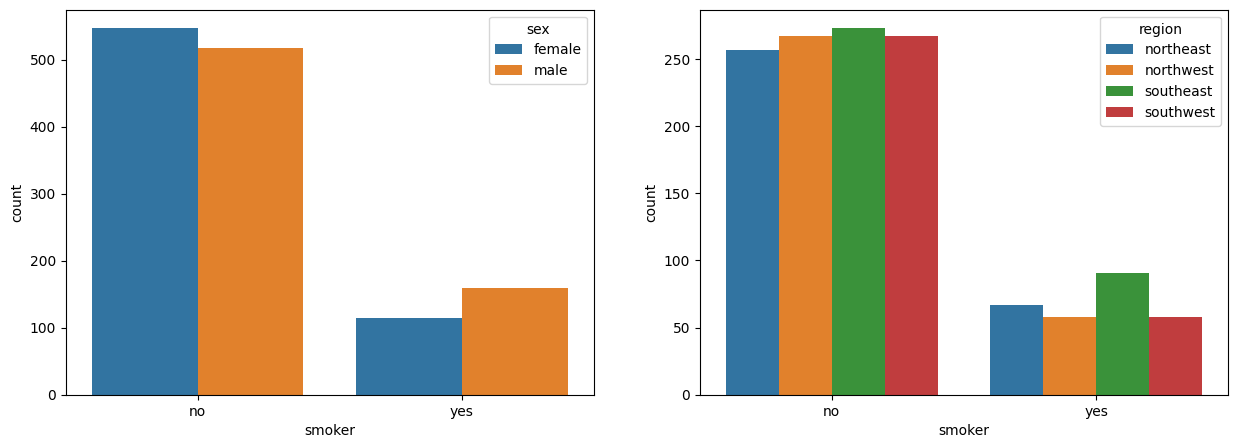

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

sb.countplot(data=edf, x='smoker', hue='sex', ax=ax1)
sb.countplot(data=edf, x='smoker', hue='region', ax=ax2)

plt.show()
plt.close()

## #04. 최종적으로 선정된 요인

|구분|변수|의미|기타|
|---|---|---|---|
|종속변수|expense|의료비|수치형데이터|
|독립변수|age|수익자의 연령|수치형 데이터|
|독립변수|bmi|비만도. 몸무게를 키의 제곱으로 나눈 값|수치형 <br> 정상범위:18.5~24.9|
|독립변수|children|의료보험이 적용되는 자녀 수|수치형 데이터|
|독립변수|sex|계약자의 성별|범주형 데이터(female/male)|
|독립변수|smoker|흡연여부|범주형 데이터(yes/no)|

## #05. 다중선형회귀분석
- case1 : 모든 변수 적용
- case2 : bmi를 제거하고 적용
- case3 : 모든 변수를 적용 + 표준화 적용
- case4 : bmi를 제거하고 적용 + 표준화 적용

### 1. 분석 케이스에 따른 분석용 데이터 생성

In [26]:
def get_df(case_number, is_scale=False):
    # bmi를 제거하지 않은 경우
    if case_number == 1:
        # 사용할 변수 이름들
        fnames1 = ['charges','age','bmi','children','sex','smoker']
        # fnames1 중에서 더미변수로 처리할 변수 이름들
        fnames2 = ['sex','smoker']
    #bmi를 제거한 경우
    elif case_number == 2:
        #사용할 변수 이름들
        fnames1 = ['charges','age','children','sex','smoker']
        #fnames1 중에서 더미변수로 처리할 변수 이름들
        fnames2 = ['sex','smoker']
    #성별을 제거한 경우
    elif case_number == 3:
        #사용할 변수 이름들
        fnames1 = ['charges','age', 'bmi', 'children','smoker']
        #fnames1 중에서 더미변수로 처리할 변수 이름들
        fnames2 = ['smoker']
    # 성별과 bmi를 제거한 경우
    elif case_number == 4:
        #사용할 변수 이름들
        fnames1 = ['charges','age','children','smoker']
        #fnames1 중에서 더미변수로 처리할 변수 이름들
        fnames2 = ['smoker']

    # 표준화를 적용하지 않은 경우
    if not is_scale:
        tmp = origin.filter(fnames1)
    # 표준화를 적용한 경우
    else:
        #미리 적용해 둔 표준화 결과를 병합
        left = merge(x_train_std_df, y_train_std_df, left_index=True, right_index=True).filter(fnames1)
        #원본에서 명목형만 다시 추출
        right = origin.filter(fnames2)
        #결합
        tmp = merge(left, right, left_index=True, right_index=True)
        None
    
    tmp2 = get_dummies(tmp, columns=fnames2, drop_first=True, dtype='int')
    return tmp2

In [28]:
target_df = get_df(3, True)
target_df.head()

,charges,age,bmi,children,smoker_yes
0,0.298584,-1.438764,-0.453320,-0.908614,1
1,-0.953689,-1.509965,0.509621,-0.078767,0
2,-0.728675,-0.797954,0.383307,1.580926,0
3,0.719843,-0.441948,-1.305531,-0.908614,0
4,-0.776802,-0.513149,-0.292556,-0.908614,0


In [30]:
#독립변수 이름만 추출
xnames = list(target_df.columns)
xnames.remove('charges')
xnames

['age', 'bmi', 'children', 'smoker_yes']

In [33]:
# 회귀분석
ols_result = helper.myOls(target_df, y='charges', x=xnames)

ols_result.table


B   표준오차  β        t   유의확률       VIF
종속변수    독립변수                                                  
charges age         0.2992  0.014  0  21.675*  0.000  1.243647
        bmi         0.1621  0.014  0  11.756*  0.000  1.082342
        children    0.0471  0.014  0   3.436*  0.001  1.008148
        smoker_yes  1.9670  0.034  0  57.904*  0.000  2.321101

In [34]:
print(ols_result.result, end='\n\n')
print(ols_result.goodness, end='\n\n')

for i in ols_result.varstr:
    print(i)

𝑅(0.750), 𝑅^2(0.749), 𝐹(998.1), 유의확률(0.00), Durbin-Watson(2.087)

charges에 대하여 age,bmi,children,smoker_yes로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(4,1333) = 998.1, p < 0.05).

age의 회귀계수는 0.2992(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
bmi의 회귀계수는 0.1621(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
children의 회귀계수는 0.0471(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
smoker_yes의 회귀계수는 1.9670(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
